In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import mne
from matplotlib import pyplot as plt
%matplotlib qt 

In [2]:
"""
load all files like for real
"""
# Load the 10-20 montage
montage = mne.channels.make_standard_montage('biosemi64')
# Get the list of channel names
electrode_names = montage.ch_names[:]

folder_path = f"C:/Users/mvmigem/Documents/data/project_1/overlap_corrected/"
full_folder_list = [folder_path + i for i in electrode_names]

# Load like the first electrode path to do stuf with
el_1_dir_list = glob.glob(full_folder_list[0]+'/*.csv')
# Make a sub list
excuded_pp = [3,14,20]
subject_list = []
excluded_path_list = []

# Creat a base df to which we append the others
for i in el_1_dir_list:
    sub = int(i.split(f'corrected_Fp1_evoked_')[1].split('.csv')[0])
    if sub not in excuded_pp:
        subject_list.append(sub)
        excluded_path_list.append(i)

sub_el1_list = []
el_base_path = folder_path + 'Fp1'
for sub_el1 in excluded_path_list:
    df1 = pd.read_csv(sub_el1)
    sub_el1_list.append(df1)

df_base = pd.concat(sub_el1_list,ignore_index=True)
df_el = df_base['selected_electrode'][0]
df_base.rename(columns={'yhat':df_el},inplace=True)
df_base = df_base.drop('selected_electrode', axis=1)

# Now for all dfs

for i, el_path in enumerate(full_folder_list[1:64]): #for ful folder except the var electrodes files
    df_el = el_path.split("/")[-1]
    sub_el_list = []
    for sub in subject_list:
        df_path = el_path + f'/corrected_{df_el}_evoked_{sub:02}.csv'
        df = pd.read_csv(df_path)
        sub_el_list.append(df)
    df_n = pd.concat(sub_el_list,ignore_index=True)
    df_base[df_el] = df_n['yhat']


In [3]:
""" 
Make visual field and set eeg stuff up
"""
# Make the updwon col
df_base['visual_field'] = np.where(df_base['position'].isin([1,2]),'up','down')

# Load the 10-20 montage
montage = mne.channels.make_standard_montage('biosemi64')
# Get the list of channel names
electrode_names = montage.ch_names
sfreq = 512
info = mne.create_info(ch_names = electrode_names,sfreq = sfreq, ch_types='eeg')


In [4]:
""" 
create mne evoked objects from df
"""

evoked_att_reg = []
evoked_att_odd = []
evoked_unatt_reg = []
evoked_unatt_odd = []

evoked_up = []
evoked_down = []

evoked_att_up = []
evoked_att_down = []
evoked_unatt_up = []
evoked_unatt_down = []

evoked_all = []

listed = [evoked_att_reg,evoked_att_odd,evoked_unatt_reg,evoked_unatt_odd,evoked_up,evoked_down,
          evoked_att_up, evoked_att_down, evoked_unatt_up, evoked_unatt_down,
          evoked_all]

for sub in subject_list:
    df_s = df_base[df_base['subject'] == sub]
    # for the experimental condditions
    df_at_re = df_s[(df_s['attention'] == 'attended') & (df_s['expectation'] == 'regular')].groupby('time')[electrode_names].mean()
    df_at_od = df_s[(df_s['attention'] == 'attended') & (df_s['expectation'] == 'odd')].groupby('time')[electrode_names].mean()
    df_un_re = df_s[(df_s['attention'] == 'unattended') & (df_s['expectation'] == 'regular')].groupby('time')[electrode_names].mean()
    df_un_od = df_s[(df_s['attention'] == 'unattended') & (df_s['expectation'] == 'odd')].groupby('time')[electrode_names].mean()
    # for visual_field
    df_up = df_s[df_s['visual_field'] == 'up'].groupby('time')[electrode_names].mean()
    df_down = df_s[df_s['visual_field'] == 'down'].groupby('time')[electrode_names].mean()

    df_attended_up = df_s[(df_s['attention'] == 'attended') & (df_s['visual_field'] == 'up')].groupby('time')[electrode_names].mean()
    df_attended_down = df_s[(df_s['attention'] == 'attended') & (df_s['visual_field'] == 'down')].groupby('time')[electrode_names].mean()
    df_unattended_up = df_s[(df_s['attention'] == 'unattended') & (df_s['visual_field'] == 'up')].groupby('time')[electrode_names].mean()
    df_unattended_down = df_s[(df_s['attention'] == 'unattended') & (df_s['visual_field'] == 'down')].groupby('time')[electrode_names].mean()
    # all conditions
    df_all = df_s.groupby('time')[electrode_names].mean()

    times = df_at_re.index
    df_listed = [df_at_re,df_at_od,df_un_re,df_un_od,df_up,df_down,df_attended_up, df_attended_down, df_unattended_up, df_unattended_down,df_all]
    for df,ev_list in zip(df_listed,listed):
        data = df.to_numpy().T * 1e-6
        ev = mne.EvokedArray(data=data,info= info, tmin = times[0]) 
        ev.set_montage(montage)
        ev.apply_baseline()
        ev_list.append(ev)

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

In [5]:
""" 
Grand averages
"""
ga_att_reg = mne.grand_average(evoked_att_reg)
ga_att_odd = mne.grand_average(evoked_att_odd)
ga_unatt_reg = mne.grand_average(evoked_unatt_reg) 
ga_unatt_odd = mne.grand_average(evoked_unatt_odd)

ga_up = mne.grand_average(evoked_up)
ga_down = mne.grand_average(evoked_down)

ga_att_up = mne.grand_average(evoked_att_up)
ga_att_down = mne.grand_average(evoked_att_down)
ga_unatt_up = mne.grand_average(evoked_unatt_up)
ga_unatt_down = mne.grand_average(evoked_unatt_down)

ga_all = mne.grand_average(evoked_all)

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


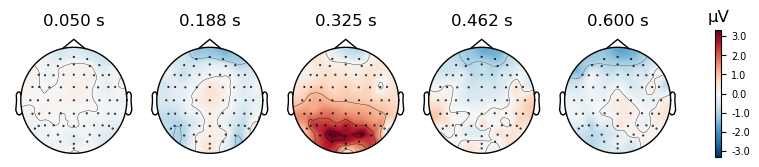

In [6]:
tim = np.linspace(0.05, 0.6, 5)
ga_att_reg.plot_topomap(ch_type="eeg", times=tim, colorbar=True)
ga_att_odd.plot_topomap(ch_type="eeg", times=tim, colorbar=True)
ga_unatt_reg.plot_topomap(ch_type="eeg", times= tim, colorbar=True)
ga_unatt_odd.plot_topomap(ch_type="eeg", times= tim, colorbar=True)
ga_up.plot_topomap(ch_type="eeg", times= tim, colorbar=True)
ga_down.plot_topomap(ch_type="eeg", times= tim, colorbar=True)

In [ ]:
for ev in evoked_all:
    tim = np.linspace(0.10, 0.2, 8)
    lim = (-3,3)
    ev.plot_topomap(ch_type="eeg", times= tim, colorbar=True)
    # ga_down.plot_topomap(ch_type="eeg", times= tim, colorbar=True, vlim = lim)

In [ ]:
tim = np.linspace(0.10, 0.2, 8)
lim = (-3,3)
ga_all.plot_topomap(ch_type="eeg", times= tim, colorbar=True)

In [7]:
""" 
not deconvolved rERP's
"""
def create_evokeds(df, condition_columns, channel_columns, info):
    """
    Function create evokeds per condition
    """
    evokeds = {}
    # Group by all condition columns and time
    grouped = df.groupby(condition_columns + ['time'])[channel_columns].mean()
    
    # Get unique condition combinations
    condition_combinations = df[condition_columns].drop_duplicates().values
    
    for combo in condition_combinations:
        # Create condition name
        condition_name = ' / '.join([f"{col}: {val}" for col, val in zip(condition_columns, combo)])
        # Create tuple for indexing
        index_tuple = tuple(combo)
        # Extract data for this condition
        condition_data = grouped.loc[index_tuple].sort_index()
        data = condition_data.values.T
        # Create evoked object
        ev = mne.EvokedArray(data, info, tmin=condition_data.index[0])
        ev.set_montage(montage)
        ev.apply_baseline()
        ev.info['bads'] = ['T8']
        ev.interpolate_bads(reset_bads=True)
        evokeds[condition_name] = ev

    return evokeds


condition_columns = ['attention','expectation','visual_field']
non_ch_order = ['subject', 'time', 'attention','expectation','visual_field']
col_order = non_ch_order + electrode_names

In [8]:

sub_path = "C:/Users/mvmigem/Documents/data/project_1/uncorrected_rERPs/"
dir_list = glob.glob(sub_path+'/*.csv')
evokeds_sub = []

for p in dir_list:
    df_sub = pd.read_csv(p)
    df_sub = df_sub[df_sub['sequence'] == 2]
    # Make the updwon col
    df_sub['visual_field'] = np.where(df_sub['position'].isin([1,2]),'up','down')
    # Drop non EEG channels
    df_sub = df_sub[~df_sub['channel'].isin(['eye_above','eye_below','eye_left','eye_right','Status'])]
    df_wide_sub = df_sub.pivot_table(
        index=non_ch_order,
        columns='channel',
        values='yhat',
        aggfunc='first'  # use 'first' if no duplicates, or 'mean'/'sum' if needed
    ).reset_index()
    df_wide_sub = df_wide_sub[col_order]
    # create evoked for every condition
    evokeds = create_evokeds(df_wide_sub,condition_columns=condition_columns,channel_columns=electrode_names,info=info)
    evokeds_sub.append(evokeds)
    

Applying baseline correction (mode: mean)
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
Applying baseline correction (mode: mean)
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
Applying baseline correction (mode: mean)
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
Applying baseline correction (mode: mean)
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor po

In [9]:
def compute_grand_averages(list_of_evoked_dicts):
    """
    Compute grand averages for each condition across subjects
    """
    # Get all condition names (should be the same for all subjects)
    condition_names = list(list_of_evoked_dicts[0].keys())
    
    grand_averages = {}
    
    for condition in condition_names:
        # Extract all evoked objects for this condition across subjects
        evokeds_for_condition = [subj_dict[condition] for subj_dict in list_of_evoked_dicts]
        
        # Compute grand average
        grand_avg = mne.grand_average(evokeds_for_condition)
        grand_averages[condition] = grand_avg
    
    return grand_averages

# Usage
grand_averages = compute_grand_averages(evokeds_sub)

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


In [10]:

uc_ga_att_reg_down = grand_averages['attention: attended / expectation: regular / visual_field: down']
uc_ga_att_odd_down = grand_averages['attention: attended / expectation: odd / visual_field: down']
uc_ga_unatt_reg_down = grand_averages['attention: unattended / expectation: regular / visual_field: down']
uc_ga_unatt_odd_down = grand_averages['attention: unattended / expectation: odd / visual_field: down']

uc_ga_att_reg_up = grand_averages['attention: attended / expectation: regular / visual_field: up']
uc_ga_att_odd_up = grand_averages['attention: attended / expectation: odd / visual_field: up']
uc_ga_unatt_reg_up = grand_averages['attention: unattended / expectation: regular / visual_field: up']
uc_ga_unatt_odd_up = grand_averages['attention: unattended / expectation: odd / visual_field: up']

uc_ga_att_up = mne.combine_evoked([uc_ga_att_reg_up,uc_ga_att_odd_up],weights='equal')
uc_ga_unatt_up = mne.combine_evoked([uc_ga_unatt_reg_up,uc_ga_unatt_odd_up],weights='equal')
uc_ga_att_down = mne.combine_evoked([uc_ga_att_reg_down,uc_ga_att_odd_down],weights='equal')
uc_ga_unatt_down = mne.combine_evoked([uc_ga_unatt_reg_down,uc_ga_unatt_odd_down],weights='equal')

In [ ]:
tim = np.linspace(0.06, 0.12, 5)
vlim = (3, -3)

ga_att_up.plot_topomap(ch_type="eeg", times=tim, colorbar=True,vlim=vlim)
ga_unatt_up.plot_topomap(ch_type="eeg", times= tim, colorbar=True,vlim=vlim)
ga_att_down.plot_topomap(ch_type="eeg", times=tim, colorbar=True,vlim=vlim)
ga_unatt_down.plot_topomap(ch_type="eeg", times= tim, colorbar=True,vlim=vlim)


In [ ]:
tim = np.linspace(0.06, 0.12, 5)
vlim = (3, -3)

uc_ga_att_up.plot_topomap(ch_type="eeg", times=tim, colorbar=True,vlim=vlim)
uc_ga_unatt_up.plot_topomap(ch_type="eeg", times= tim, colorbar=True,vlim=vlim)
uc_ga_att_down.plot_topomap(ch_type="eeg", times=tim, colorbar=True,vlim=vlim)
uc_ga_unatt_down.plot_topomap(ch_type="eeg", times= tim, colorbar=True,vlim=vlim)

In [13]:
# Find common time range
common_tmin = max(ga_att_up.times[0], uc_ga_att_up.times[0])
common_tmax = min(ga_att_up.times[-1], uc_ga_att_up.times[-1])

ga_att_up = ga_att_up.crop(common_tmin, common_tmax)
ga_unatt_up = ga_unatt_up.crop(common_tmin, common_tmax)
ga_att_down = ga_att_down.crop(common_tmin, common_tmax)
ga_unatt_down = ga_unatt_down.crop(common_tmin, common_tmax)


# diff_att_up = mne.combine_evoked([ga_att_up_cropped, uc_ga_att_up_cropped], weights=[1, -1])

In [14]:
diff_att_up = mne.combine_evoked([ga_att_up,uc_ga_att_up],weights=[1,-1])
diff_unatt_up = mne.combine_evoked([ga_unatt_up,uc_ga_unatt_up],weights=[1,-1])
diff_att_down = mne.combine_evoked([ga_att_down,uc_ga_att_down],weights=[1,-1])
diff_unatt_down = mne.combine_evoked([ga_unatt_down,uc_ga_unatt_down],weights=[1,-1])

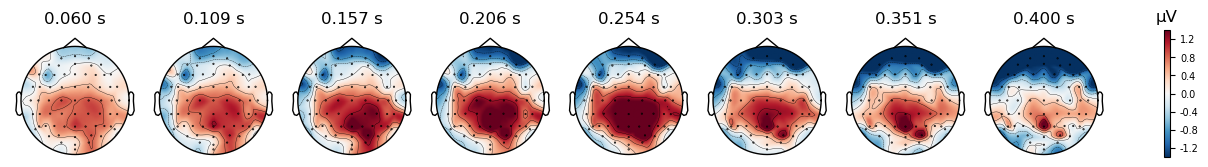

In [34]:
tim = np.linspace(0.06, 0.4,8)
vlim = (-1.4, 1.4)

# diff_att_up.plot_topomap(ch_type="eeg", times=tim, colorbar=True,vlim=vlim)
# diff_unatt_up.plot_topomap(ch_type="eeg", times= tim, colorbar=True,vlim=vlim)
# diff_att_down.plot_topomap(ch_type="eeg", times=tim, colorbar=True,vlim=vlim)
# diff_unatt_down.plot_topomap(ch_type="eeg", times= tim, colorbar=True,vlim=vlim)
diff_att.plot_topomap(ch_type="eeg", times=tim, colorbar=True,vlim=vlim)
diff_unatt.plot_topomap(ch_type="eeg", times= tim, colorbar=True,vlim=vlim)


In [32]:
scale = [-12,12]
ev_names = ['attended_up','unattended_up','attended_down','unattended_down']

evokeds_list = [diff_att_up,
                diff_unatt_up,
                diff_att_down,
                diff_unatt_down]

# conds = ('seq1','seq2','seq3','seq4')
norm = dict(zip(ev_names, evokeds_list))

mne.viz.plot_compare_evokeds(norm, picks=['POz','Pz','P1','P2'], vlines=[0.05,0.1],combine='mean')


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


[<Figure size 800x600 with 1 Axes>]

In [31]:
diff_att = mne.combine_evoked([diff_att_down,diff_att_up],weights=[1,1])
diff_unatt = mne.combine_evoked([diff_unatt_down,diff_unatt_up],weights=[1,1])

ev_names = ['attended','unattended']

evokeds_list = [diff_att,
                diff_unatt]

norm = dict(zip(ev_names, evokeds_list))

mne.viz.plot_compare_evokeds(norm, picks=['POz','Pz','P1','P2'], vlines=[0.05,0.1],combine='mean')

combining channels using "mean"
combining channels using "mean"


[<Figure size 800x600 with 1 Axes>]